### **SPLEX PROJECT: Legendary predictions based on Pokémon stats**
*LEGOFFIC LIAM and ZHONG YANN*

This project is a data science exploration project in which we seek to use fundamental methods in data science analysis, most notably clustering and dimensionality reduction, in order to analyse and predict whethere "Pokémon", inhabitants of one of the world's greatest grossing franchises, are legendary or not. Moreover, we would also like to answer other questions that pertain to the correlation of a Pokémon's stats with itself - are its stats predictable enough to guess, based on one or two stats?

Currently, the fundamental questions we seek to answer are:
- Can we infer a Pokémon's legendary status from its base stat total? (likely, yes)
- Can we infer a Pokémon's legendary status from its individual stats (hard to say)
- Can we infer a Pokémon's legendary status from its competitive usage tiering? (OU, UU, etc. To be implemented if we have sufficient time)
- Can we infer a Pokémon's name from its base stat total and its belonging to either group? (Prediction)
- Do Pokémon's attack stats correlate with their defense stats?
- Do Pokémon's special attack stats correlate with their special defense stats?
- Do Pokémon's HP stats anti-correlate with their speed stats? ("Fat" Pokémon)

With more questions to come. 

Todo:
- Answer the questions above
- Incorporate OU and Ubers stats into csv
- Clustering methods: is there a method to the madness? Can "logical" groups form?
- Dimensionality reduction? => UMAP, t-SNE

In [30]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from math import pi
# from wordcloud import WordCloud
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import graphviz

# To change matplotlib figure size
matplotlib.rcParams['figure.dpi'] = 100    

In [31]:
# Read in input file
data = pd.read_csv('data/Pokemon.csv')
# Read in alternative, more complete input file
data2 = pd.read_csv('data/pokemon_dataset_2.csv')

data
#data2

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


### STEP 1: Visualising the dataset

Before anything, we would like to visualise the rough spread of the Pokémon's base stat totals, as well as individual stats, over a density plot. 
This should enable us to have a global idea of what the general spread of stats, as well as outliers, is.
We would also like to look at the rough number of Pokémon per types in a histogram.

In [32]:
# Split legendaries and non-legendaries into two datasets
legendaries = data[data['Legendary']==True]
plebians = data[data['Legendary']==False]
raw_stats_no_total = data[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]]
raw_stats = data[["Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Legendary"]]

#legendaries
#plebians
#raw_stats

The average base stat total for legendaries and non legendaries is respectively 630.2666666666667 and 414.9131034482759
Below, a density distribution of base stat totals of all Pokémon over 6 generations:


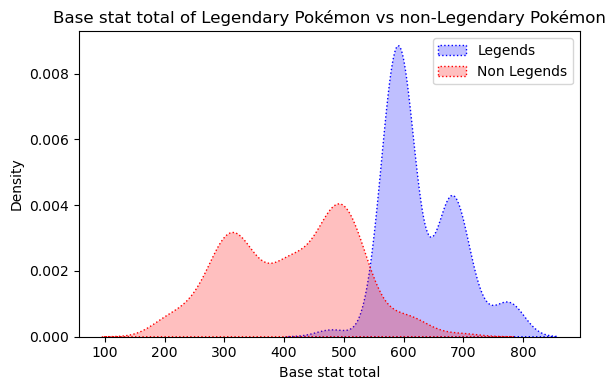

In [33]:
# Calculate average base stats
avg_l_base = sum(legendaries["Total"])/len(legendaries)
avg_p_base = sum(plebians["Total"])/len(plebians)

# Calculate average stats per generation for putting into a radar plot

print("The average base stat total for legendaries and non legendaries is respectively "+ str(avg_l_base) + " and " + str(avg_p_base))

# Append base stats into list
l_base_list = []
p_base_list = []

for base in legendaries["Total"]:
    l_base_list.append(base)
for base in plebians["Total"]:
    p_base_list.append(base)

print("Below, a density distribution of base stat totals of all Pokémon over 6 generations:")

# Density plot
fig, ax = plt.subplots()
sns.kdeplot(l_base_list,shade=True,color="blue",label="Legends",linestyle ="dotted")
sns.kdeplot(p_base_list,shade=True,color="red",label="Non Legends",linestyle ="dotted")
plt.title("Base stat total of Legendary Pokémon vs non-Legendary Pokémon")
plt.xlabel("Base stat total")
plt.ylabel("Density")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Below, the boxen plot distribution of base stats per generation:


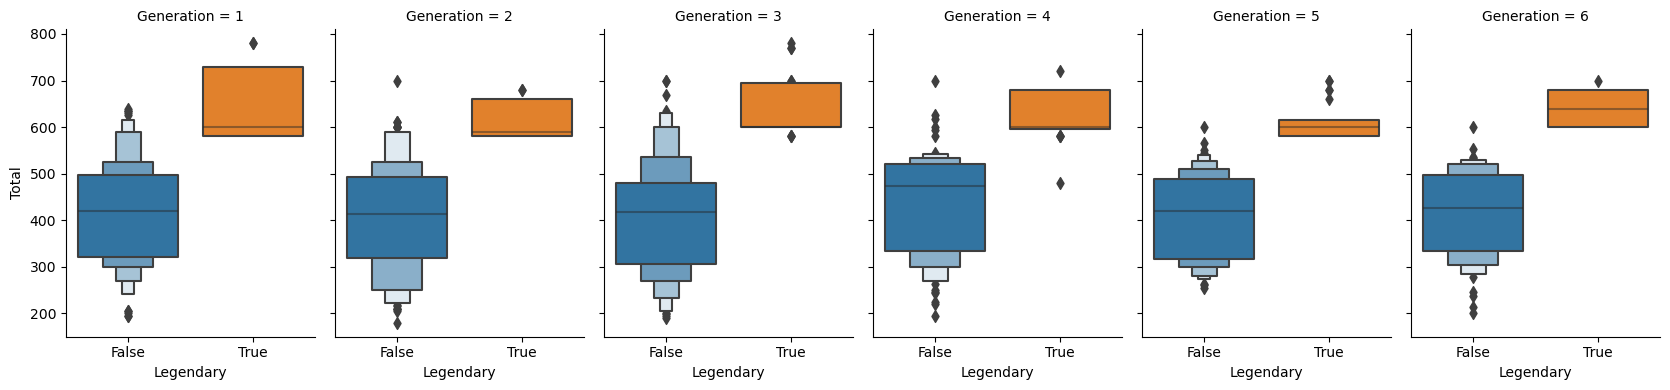

In [34]:
# Visualise boxplots of base stat totals per generation
print("Below, the boxen plot distribution of base stats per generation:")
base_total_plot = sns.catplot(x = "Legendary", y = "Total", col = "Generation", data = data, kind = "boxen", height=4, aspect=.7)

Below, the point plot distribution of base stats per generation with type 1 grouped by color:


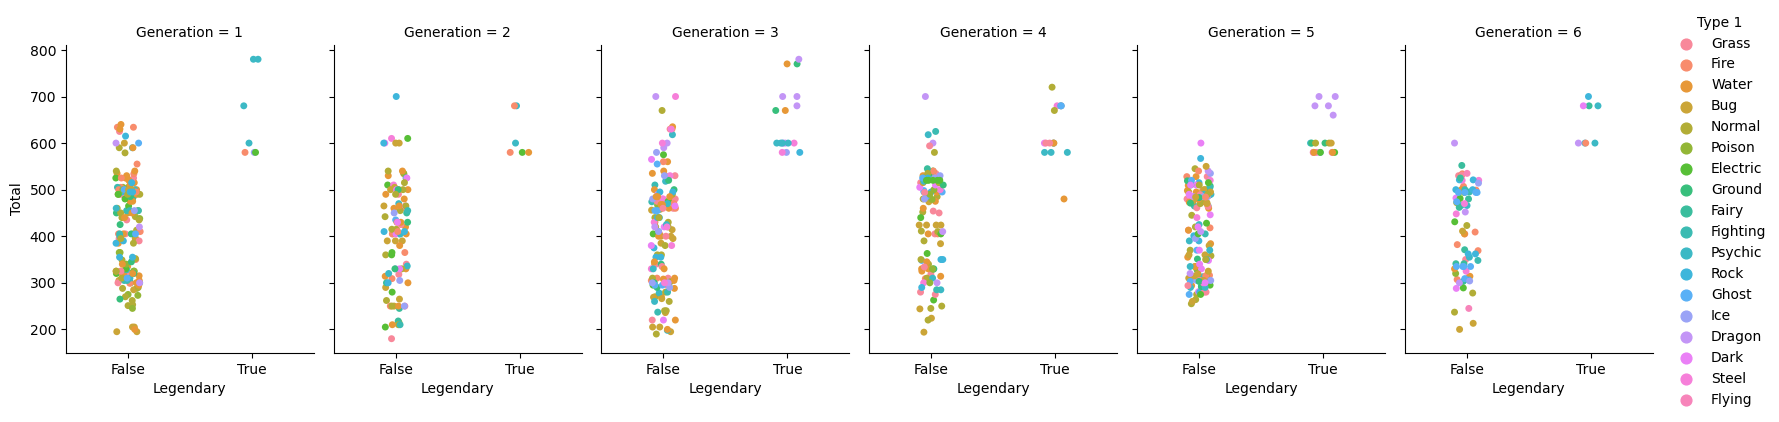

In [35]:
# Similar plot, with confounded type 1 visualisation on a point plot
print("Below, the point plot distribution of base stats per generation with type 1 grouped by color:")
base_total_plot_2 = sns.catplot(x = "Legendary", y = "Total", col = "Generation", hue = "Type 1", data = data, height=4, aspect=.7)

Below, the box plot distribution of stats with outliers, for all Pokémon regardless of generation:


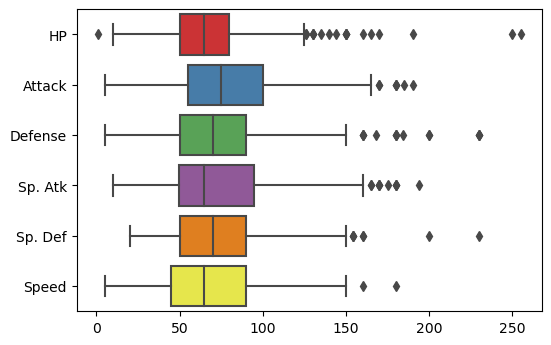

In [36]:
print("Below, the box plot distribution of stats with outliers, for all Pokémon regardless of generation:")
stats_plot = sns.boxplot(data=raw_stats_no_total, orient="h", palette="Set1", showfliers=True)
#stats_plot_no_out = sns.boxplot(data=raw_stats_no_total, orient="h", palette="Set1", showfliers=False) # Remove outliers

In [92]:
# What are the average stats over every generation?
stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
stats_list = round(data[stats].mean(),2)
print("Average stats over every generation:")
print("HP:" + str(stats_list[0]) + "; Atk:"+ str(stats_list[1]) + "; Def:"+ str(stats_list[2])+ "; SpAtk:"+ str(stats_list[3])+ "; SpDef:"+ str(stats_list[4])+ "; Speed:"+ str(stats_list[5]))

# Split data by generation and get mean of stats
g1 = data[data["Generation"] == 1]
g2 = data[data["Generation"] == 2]
g3 = data[data["Generation"] == 3]
g4 = data[data["Generation"] == 4]
g5 = data[data["Generation"] == 5]
g6 = data[data["Generation"] == 6]
# Get average stats
stats_list_g1 = list(round(g1[stats].mean(),2))
stats_list_g2 = list(round(g2[stats].mean(),2))
stats_list_g3 = list(round(g3[stats].mean(),2))
stats_list_g4 = list(round(g4[stats].mean(),2))
stats_list_g5 = list(round(g5[stats].mean(),2))
stats_list_g6 = list(round(g6[stats].mean(),2))
# Concatenate
stats_list_complete = list(zip(stats_list_g1,stats_list_g2,stats_list_g3,stats_list_g4,stats_list_g5,stats_list_g6))

print("Average stats per generation:")
for line in stats_list_complete:
    print("HP:" + str(line[0]) + "; Atk:"+ str(line[1]) + "; Def:"+ str(line[2])+ "; SpAtk:"+ str(line[3])+ "; SpDef:"+ str(line[4])+ "; Speed:"+ str(line[5]))

Average stats over every generation:
HP:69.26; Atk:79.0; Def:73.84; SpAtk:72.82; SpDef:71.9; Speed:68.28
Average stats per generation:
HP:65.82; Atk:71.21; Def:66.54; SpAtk:73.08; SpDef:71.79; Speed:68.27
HP:76.64; Atk:72.03; Def:81.62; SpAtk:82.87; SpDef:82.07; Speed:75.8
HP:70.86; Atk:73.39; Def:74.1; SpAtk:78.13; SpDef:72.33; Speed:76.68
HP:71.82; Atk:65.94; Def:75.81; SpAtk:76.4; SpDef:71.99; Speed:74.29
HP:69.09; Atk:73.91; Def:71.22; SpAtk:77.19; SpDef:68.74; Speed:74.89
HP:72.58; Atk:61.81; Def:66.92; SpAtk:71.34; SpDef:68.08; Speed:66.44


In [97]:
def draw_spider_plot_stats(list_stats,color,generation):
# Create angles
    stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
    if list_stats[0] != list_stats[-1]: # Close the circle
        list_stats += list_stats[:1]
    angles = [n / 6 * 2 * pi for n in range(6)] # 6 stats
    angles += angles[:1] # Add in first one again to close the circle ("7th")

# Initialise the spider plot
    ax = plt.subplot(111, polar=True)
# Draw axes
    plt.xticks(angles[:-1], stats, color=color, size=8)
    ax.set_rlabel_position(0)
    plt.yticks([20,40,60,80],["20","40","60","80"], color=color, size=7)
    plt.ylim(0,100)
# Plot data and fill area
    ax.plot(angles, list_stats, color,linewidth=1, linestyle='solid')
    ax.fill(angles, list_stats, color, alpha=0.1)
    plt.title("Generation " + str(generation) + " stat distribution", color=color)
    plt.show()

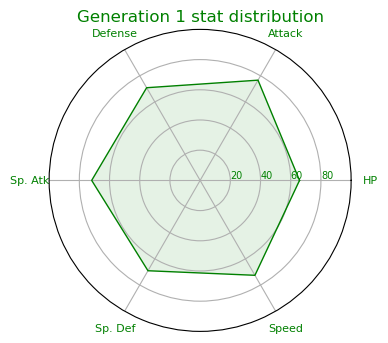

In [98]:
color = "green"
generation = 1
draw_spider_plot_stats(stats_list_g1,color,generation)

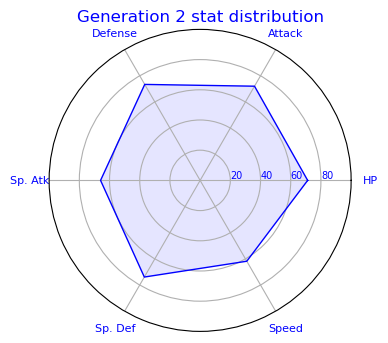

In [86]:
color = "blue"
generation = 2
draw_spider_plot_stats(stats_list_g2,color,generation)

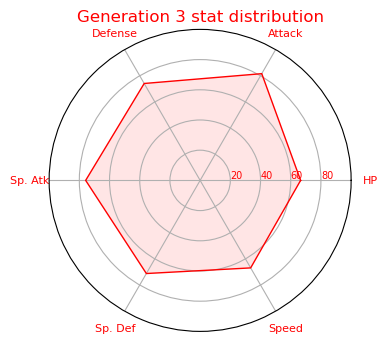

In [87]:
color = "red"
generation = 3
draw_spider_plot_stats(stats_list_g3,color,generation)

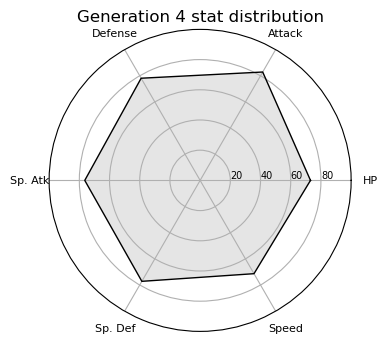

In [88]:
color = "black"
generation = 4
draw_spider_plot_stats(stats_list_g4,color,generation)

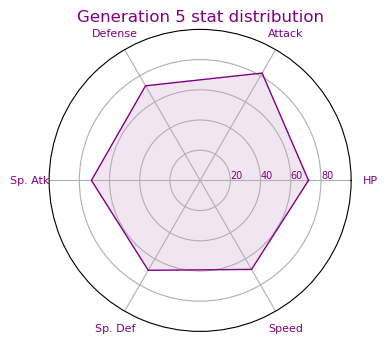

In [89]:
color = "purple"
generation = 5
draw_spider_plot_stats(stats_list_g5,color,generation)

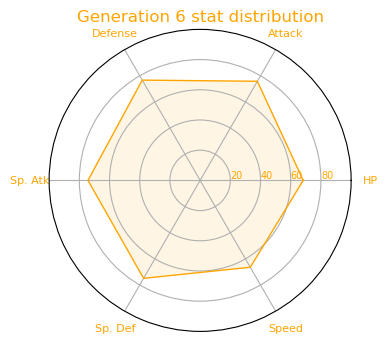

In [91]:
color = "orange"
generation = 6
draw_spider_plot_stats(stats_list_g6,color,generation)

### STEP 2: Decision tree and random forest

The next step was to apply a simple decision tree to determine if a Pokémon was legendary, or not.

In [20]:
# Using the tree library from sklearn in order to build a tree to decide if a Pokémon is legendary
clf = tree.DecisionTreeClassifier()
feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
clf = clf.fit(data[feature_int], data['Legendary'])
class_pred_DT = clf.predict(data[feature_int])

# Use graphviz to export our decision tree into a visible PDF
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_int, 
                                class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('Legendary status')

/home/yannz/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


  (0, 0)	1
  (0, 12)	1
  (0, 26)	1
  (0, 46)	1
  (0, 48)	1
  (0, 49)	1


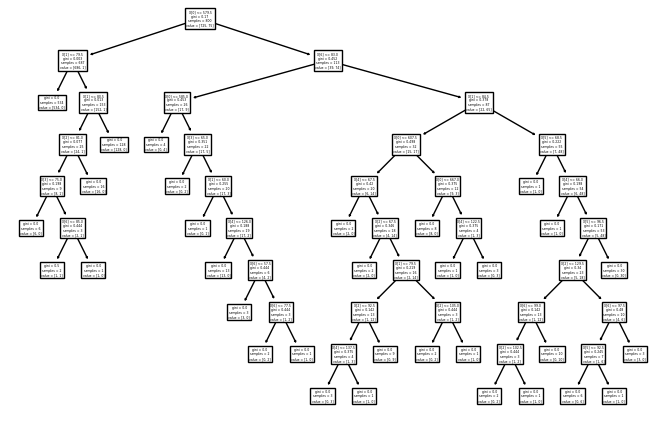

In [23]:
# A quick view of the generated tree (for a more detailed view, refer to the PDF file)
tree.plot_tree(clf)
plt.show

In [19]:
# Example: What is the decision path for a (hypothetical) Pokémon of stats: 700, 100, 180, 120, 30, 70 and 200?
print(clf.decision_path([[700, 100, 180, 120, 30, 70, 200]]))

  (0, 0)	1
  (0, 12)	1
  (0, 26)	1
  (0, 46)	1
  (0, 47)	1


/home/yannz/anaconda3/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


[0.39073476 0.08393827 0.04904614 0.06680186 0.18185804 0.08710185
 0.14051906]


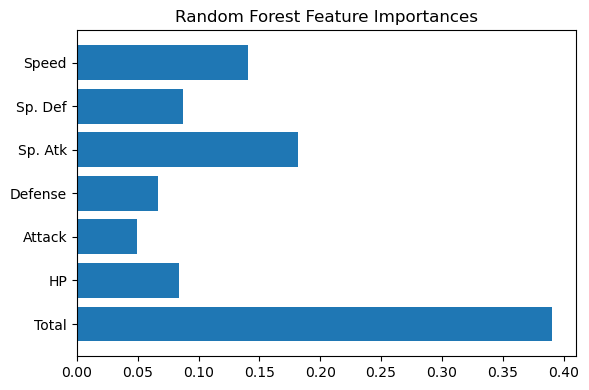

In [27]:
# Using the random forest classifier to fit a number of decision trees on various sub samples of dataset
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(data[feature_int], data['Legendary'])
class_pred_RF = clf.predict(data[feature_int])

# Output the importance of each feature
importance = clf.feature_importances_
print(importance)

y_ticks = np.arange(0, len(feature_int))
fig, ax = plt.subplots()
ax.barh(y_ticks, importance)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_int)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

### STEP 3: Learning

Learning a Pokémon's "legendariness" ==> use weight_model function

In [55]:
# TODO

### STEP 4: Clustering and dimensionality reduction
I would like to try clustering Pokémon/Legendaries according to their generation to see if generational shifts affect anything.

Relevant links: 
- https://rstudio-pubs-static.s3.amazonaws.com/356278_b48024a57c824aae9981d04e17c77686.html#clustering---legendary-pokemon
- https://medium.com/@patrickmartinaz/pokeml-part-4-clustering-4bab6fc9b8d8
- https://fderyckel.github.io/machinelearningwithr/hierclust.html#example-on-the-pokemon-dataset
- https://medium.com/@robisonsaalfeld/gotta-map-em-all-dimensionality-reduction-of-pok%C3%A9mon-data-using-r-a14423ccf25a